In [20]:
import os
import numpy as np

from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt

In [21]:
# Directory paths
train_dir = r"chest_xray\train"
test_dir = r"chest_xray\test"

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Function to display images from a given directory
def display_images_from_directory(directory, label, n_images=5):
    label_dir = os.path.join(directory, label)
    images = os.listdir(label_dir)

    # Display the first n_images from the directory
    plt.figure(figsize=(20, 20))
    for i, img_name in enumerate(images[:n_images]):
        img_path = os.path.join(label_dir, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, n_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{label} Image")
        plt.axis('off')
    plt.show()

Displaying Normal images from training set:


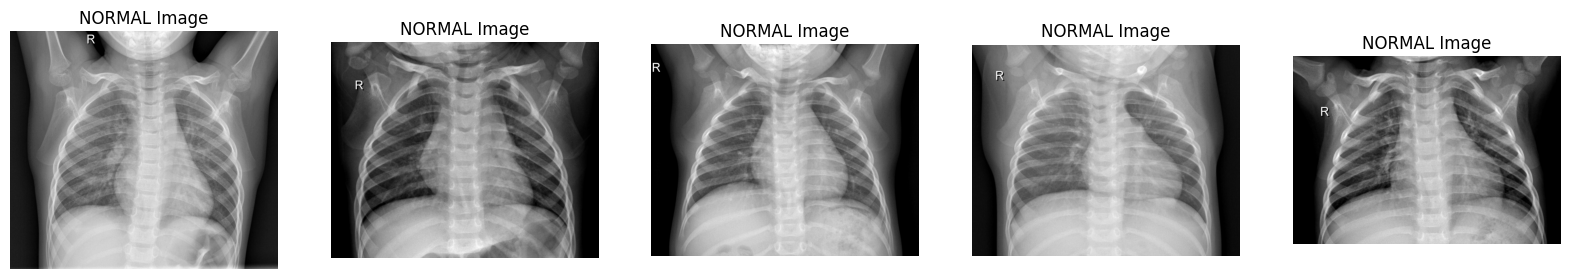

In [23]:
# Display images from the training set
print("Displaying Normal images from training set:")
display_images_from_directory(train_dir, 'NORMAL', n_images=5)



Displaying Pneumonia images from training set:


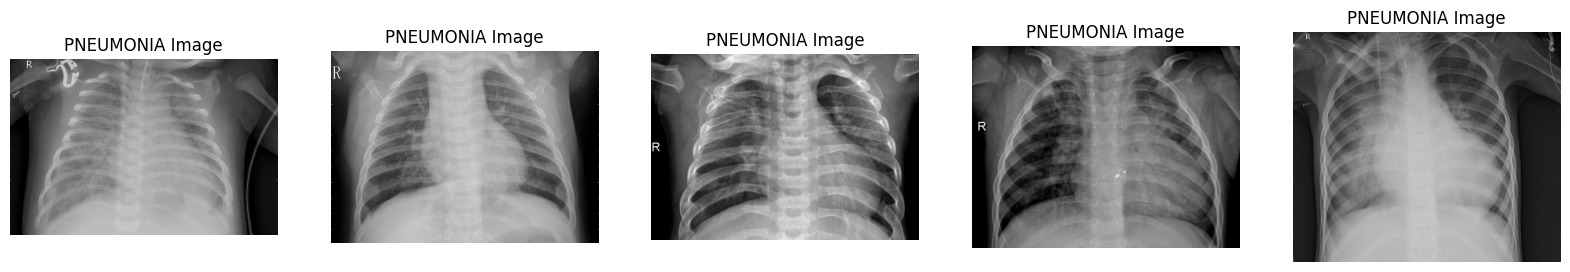

In [24]:
print("Displaying Pneumonia images from training set:")
display_images_from_directory(train_dir, 'PNEUMONIA', n_images=5)



Class distribution :


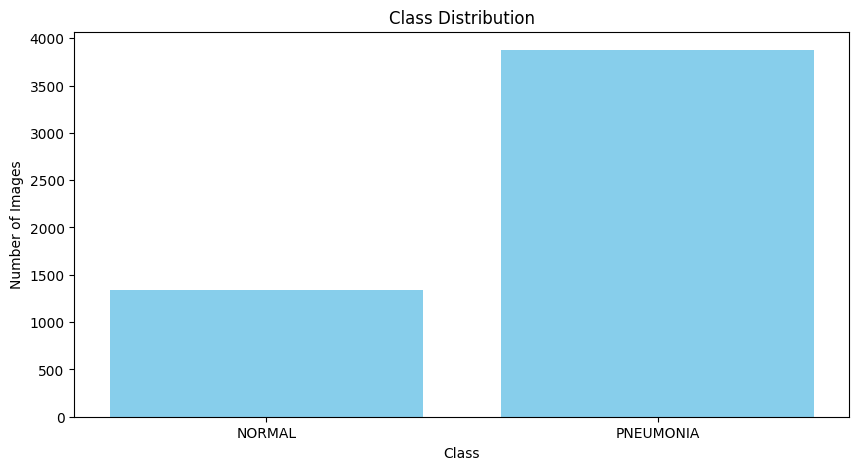

In [25]:
import os
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution(directory, title='Class Distribution'):
    # Initialize a Counter to count images in each class
    class_counts = Counter()
    
    # Iterate over each class directory
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            # Count the number of files in the directory
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = num_images
    
    class_names = list(class_counts.keys())
    counts = list(class_counts.values())

    # Plot class distribution
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.show()


print("Class distribution :")
plot_class_distribution(train_dir, 'Class Distribution')

In [26]:

# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data augmentation and normalization for training
train_image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False, 
    fill_mode='nearest'
)

# Only normalization for validation/testing
test_image_gen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the training dataset
train_data_gen = train_image_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale', 
    class_mode='binary'
)

# Load and preprocess the testing dataset
test_data_gen = test_image_gen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale', 
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# LogisticRegression

In [27]:
import numpy as np

# Flatten images for Logistic Regression
def flatten_images(image_gen):
    images = []
    labels = []
    for i in range(len(image_gen)):
        batch = image_gen[i]
        batch_images = batch[0]
        batch_labels = batch[1]
        # Flatten each image
        flattened_images = batch_images.reshape(batch_images.shape[0], -1)
        images.extend(flattened_images)
        labels.extend(batch_labels)
    return np.array(images), np.array(labels)

train_images, train_labels = flatten_images(train_data_gen)
test_images, test_labels = flatten_images(test_data_gen)


In [28]:
# Compute class weights
classes = np.unique(train_labels)
class_weights = compute_class_weight('balanced', classes=classes, y=train_labels)
class_weights_dict = dict(zip(classes, class_weights))

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Create a Logistic Regression pipeline with class weights
log_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, class_weight=class_weights_dict))
])

In [30]:
# Train the logistic regression model
log_reg.fit(train_images, train_labels)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(class_weight={0.0: 1.9448173005219984,
                                                  1.0: 0.6730322580645162},
                                    max_iter=1000))])

In [31]:
# Predict on the test set
predictions = log_reg.predict(test_images)

In [32]:
# Print classification report
print("Logistic Regression Classification Report:")
print(classification_report(test_labels, predictions))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.50      0.57       234
         1.0       0.74      0.85      0.79       390

    accuracy                           0.71       624
   macro avg       0.70      0.67      0.68       624
weighted avg       0.71      0.71      0.70       624



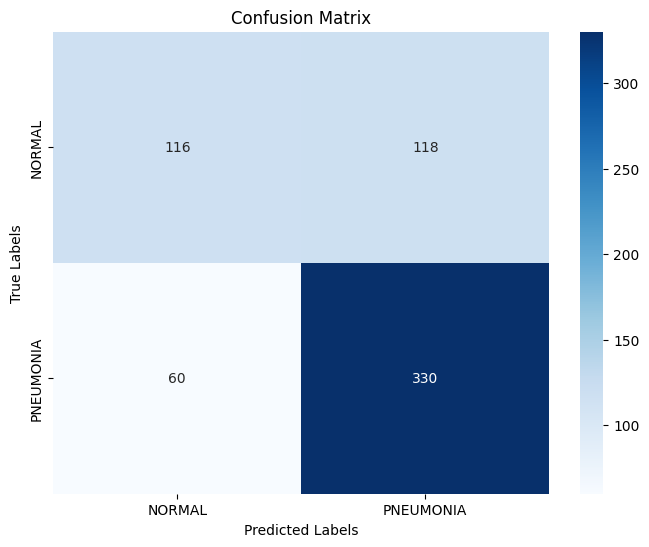

In [33]:
import seaborn as sns
from sklearn.metrics import  confusion_matrix



# Generate confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_data_gen.class_indices.keys(),
            yticklabels=test_data_gen.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [34]:
from sklearn.metrics import  accuracy_score


# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)

# Print accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 71.47%


In [35]:
import pickle
# Save the trained model using pickle
model_filename = 'logistic_regression_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(log_reg, file)

print(f"Model saved as {model_filename}")

Model saved as logistic_regression_model.pkl


# Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import numpy as np
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(class_weight=class_weights_dict)

# Train and evaluate
dt_classifier.fit(train_images.reshape(train_images.shape[0], -1), train_labels)


DecisionTreeClassifier(class_weight={0.0: 1.9448173005219984,
                                     1.0: 0.6730322580645162})

In [37]:

test_images_reshaped = test_images.reshape(test_images.shape[0], -1)
predictions_dt = dt_classifier.predict(test_images_reshaped)

In [38]:
# Print classification report
print("Decision Tree Classification Report:")
print(classification_report(test_labels, predictions_dt))

Decision Tree Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.48      0.56       234
         1.0       0.73      0.86      0.79       390

    accuracy                           0.72       624
   macro avg       0.71      0.67      0.68       624
weighted avg       0.71      0.72      0.71       624



In [39]:


# Calculate accuracy
accuracy_dt = accuracy_score(test_labels, predictions_dt)

# Print accuracy
print(f'Accuracy: {accuracy_dt * 100:.2f}%')

Accuracy: 71.96%


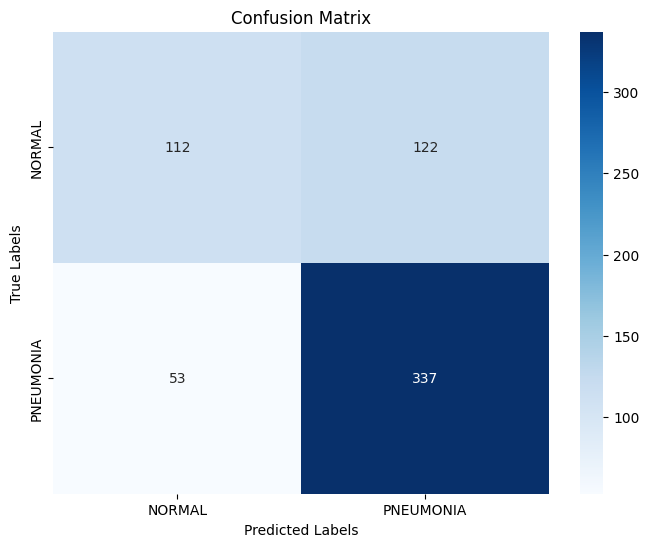

In [40]:

# Generate confusion matrix
cm_dt = confusion_matrix(test_labels, predictions_dt)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_data_gen.class_indices.keys(),
            yticklabels=test_data_gen.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [41]:

# Save the trained model using pickle
dt_model_filename = 'decision_tree_classifier_model.pkl'
with open(dt_model_filename, 'wb') as file:
    pickle.dump(dt_classifier, file)

print(f"Decision Tree model saved as {dt_model_filename}")

Decision Tree model saved as decision_tree_classifier_model.pkl


# Artificial Neural Network (ANN)

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

def build_ann_model(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(1, activation='sigmoid')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  # Adjusted learning rate
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model


In [43]:

ann_model = build_ann_model((IMG_HEIGHT, IMG_WIDTH, 1))

C:\Users\kunch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
# Train and evaluate
history_ann = ann_model.fit(
    train_data_gen,
    epochs=10,
    validation_data=test_data_gen,
    class_weight=class_weights_dict
)

Epoch 1/10


C:\Users\kunch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.5488 - loss: 8.3850 - precision: 0.7803 - recall: 0.5493 - val_accuracy: 0.3862 - val_loss: 8.0391 - val_precision: 1.0000 - val_recall: 0.0179
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 261ms/step - accuracy: 0.5824 - loss: 6.9669 - precision: 0.8168 - recall: 0.5722 - val_accuracy: 0.7212 - val_loss: 6.0457 - val_precision: 0.7488 - val_recall: 0.8333
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 300ms/step - accuracy: 0.6108 - loss: 6.0034 - precision: 0.8308 - recall: 0.5947 - val_accuracy: 0.7660 - val_loss: 5.2245 - val_precision: 0.8653 - val_recall: 0.7410
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 289ms/step - accuracy: 0.6341 - loss: 5.2249 - precision: 0.8381 - recall: 0.6230 - val_accuracy: 0.4231 - val_loss: 5.7743 - val_precision: 0.9167 - val_recall: 0.0846
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 280ms/step - accuracy: 0.6384 - loss: 4.6193 - precision: 0.8425 - recall: 0.6324 - val_accuracy: 0.6442 - val_loss

In [45]:
# Evaluate the ANN model
ann_test_loss, ann_test_acc, ann_test_precision, ann_test_recall = ann_model.evaluate(test_data_gen)
print(f'ANN Test accuracy: {ann_test_acc:.2f}')
print(f'ANN Test precision: {ann_test_precision:.2f}')
print(f'ANN Test recall: {ann_test_recall:.2f}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.7326 - loss: 2.6775 - precision: 0.8063 - recall: 0.7398
ANN Test accuracy: 0.71
ANN Test precision: 0.80
ANN Test recall: 0.73


In [46]:
# Defining confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    
    # Convert predicted probabilities to binary values (0 or 1)
    y_pred = np.round(y_pred).astype(int).reshape(-1)

    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_data_gen.class_indices.keys(),
                yticklabels=test_data_gen.class_indices.keys())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step


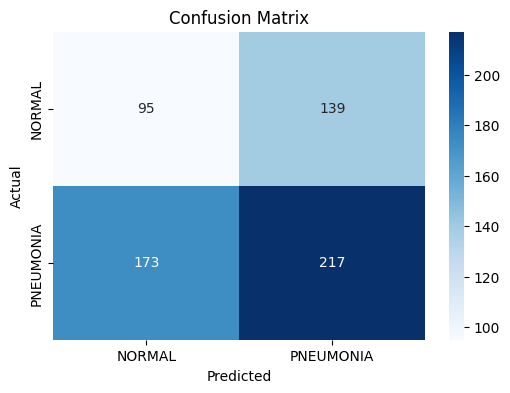

In [47]:
# Plotting confusion matrix
y_pred_ann = ann_model.predict(test_data_gen)
plot_confusion_matrix(test_labels, y_pred_ann)

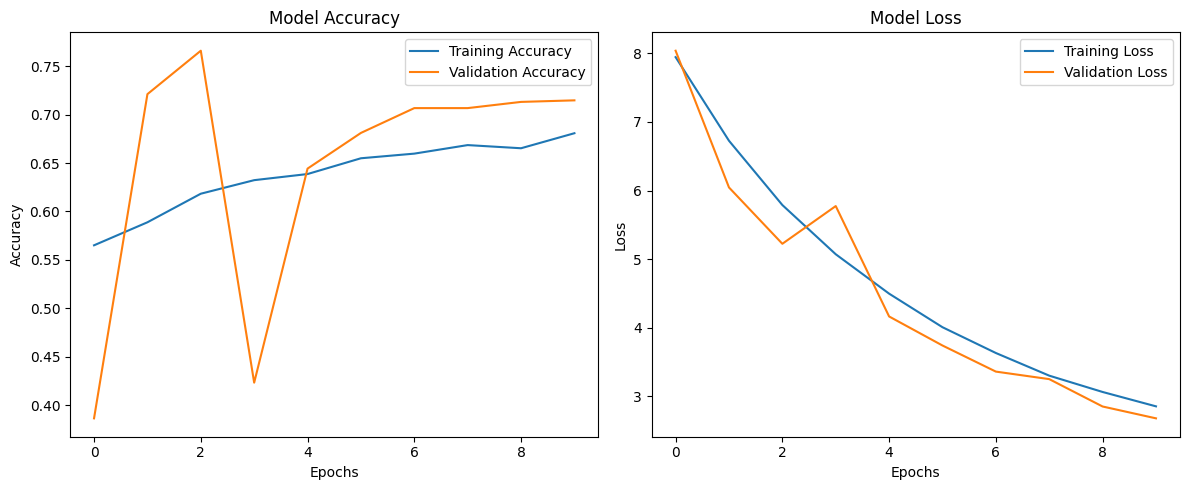

In [48]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_ann.history['accuracy'], label='Training Accuracy')
plt.plot(history_ann.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_ann.history['loss'], label='Training Loss')
plt.plot(history_ann.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

In [49]:

# Save the dictionary using pickle
with open('ann_model.pkl', 'wb') as f:
    pickle.dump(ann_model, f)

# CNN 

In [50]:
def build_cnn_model(input_shape=(224, 224, 1), num_classes=1):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy' ,
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

In [51]:
cnn_model = build_cnn_model((IMG_HEIGHT, IMG_WIDTH, 1))

C:\Users\kunch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_.keras', monitor='val_accuracy', save_best_only=True)

In [53]:
# Fit the CNN model with class weights and callbacks
history_cnn = cnn_model.fit(
    train_data_gen,
    epochs=20,
    validation_data=test_data_gen,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 602ms/step - accuracy: 0.7157 - loss: 0.5901 - precision_1: 0.8923 - recall_1: 0.7003 - val_accuracy: 0.8157 - val_loss: 0.4307 - val_precision_1: 0.7932 - val_recall_1: 0.9538
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 564ms/step - accuracy: 0.8303 - loss: 0.3811 - precision_1: 0.9599 - recall_1: 0.8062 - val_accuracy: 0.7147 - val_loss: 0.5592 - val_precision_1: 0.9732 - val_recall_1: 0.5590
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 599ms/step - accuracy: 0.8442 - loss: 0.3427 - precision_1: 0.9609 - recall_1: 0.8272 - val_accuracy: 0.8542 - val_loss: 0.3525 - val_precision_1: 0.8824 - val_recall_1: 0.8846
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 601ms/step - accuracy: 0.8697 - loss: 0.2936 - precision_1: 0.9690 - recall_1: 0.8524 - val_accuracy: 0.8590 - val_loss: 0.3176 - val_precision_1: 0.8756 - val_recall_1: 0.9026
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 582ms/step - accuracy: 0.8791 - loss: 0.2766 - precision_1: 0.9693 - re

In [54]:
# Evaluate the CNN model
cnn_test_loss, cnn_test_acc, cnn_test_precision, cnn_test_recall = cnn_model.evaluate(test_data_gen)
print(f"CNN Test accuracy: {cnn_test_acc:.2f}")
print(f"CNN Test precision: {cnn_test_precision:.2f}")
print(f"CNN Test recall: {cnn_test_recall:.2f}")
print(f"CNN Test loss: {cnn_test_loss:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.8881 - loss: 0.2947 - precision_1: 0.9003 - recall_1: 0.9172
CNN Test accuracy: 0.90
CNN Test precision: 0.91
CNN Test recall: 0.93
CNN Test loss: 0.26


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step


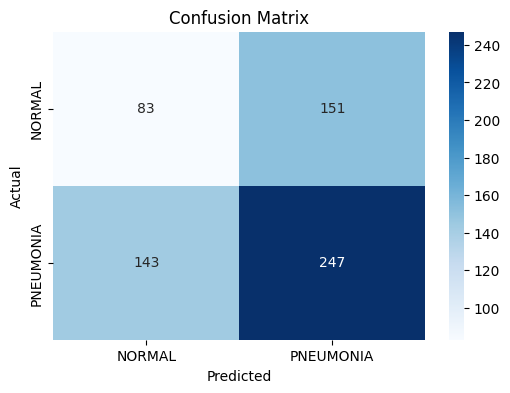

In [55]:
#Plotting confusion matrix
y_pred_cnn = cnn_model.predict(test_data_gen)
plot_confusion_matrix(test_labels, y_pred_cnn)


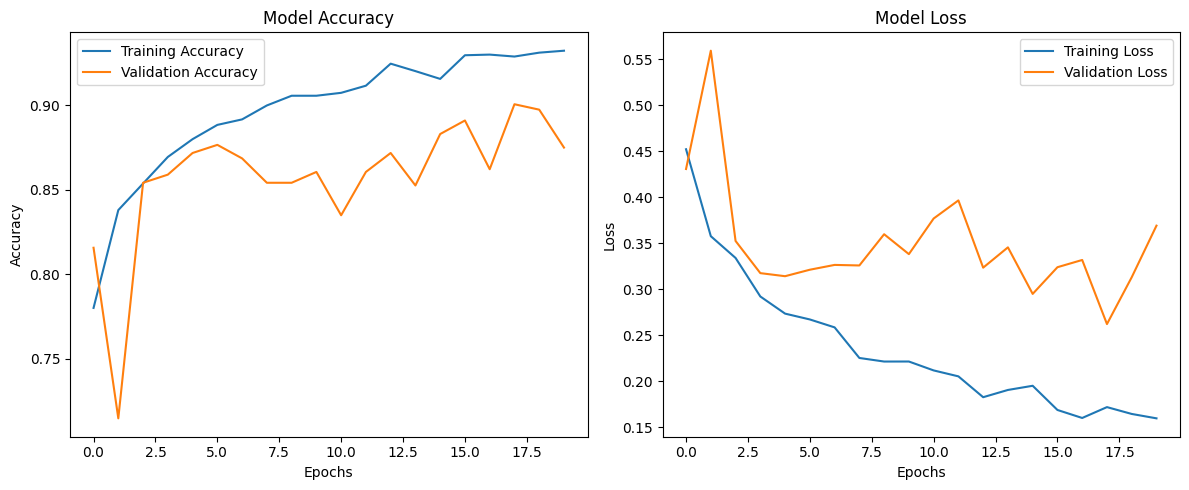

In [56]:

# Plotting accuracy
plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


In [ ]:
# Save the dictionary using pickle
with open('cnn_model.pkl', 'wb') as f:
    pickle.dump(cnn_model, f)

# Hyper Parameter Tuning

In [57]:
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


def cnn_model_builder(hp):
    model = Sequential([
        Conv2D(hp.Int('conv_1_filters', min_value=64, max_value=128, step=32), (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('conv_2_filters', min_value=64, max_value=128, step=64), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(hp.Int('dense_units', min_value=128, max_value=256, step=128), activation='relu'),
        Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.1)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='binary_crossentropy',
         metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model

In [58]:
# Initialize Keras Tuner
tuner = kt.RandomSearch(
    cnn_model_builder,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='my_dir',
    project_name='image'
)

# Perform the hyperparameter search
tuner.search(
    train_data_gen,
    epochs=20,
    validation_data=test_data_gen,
    callbacks=[early_stopping, model_checkpoint]
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]



Trial 5 Complete [00h 56m 10s]
val_accuracy: 0.8485576808452606

Best val_accuracy So Far: 0.8629807531833649
Total elapsed time: 09h 30m 31s


C:\Users\kunch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
